In [56]:
# get pytorch device
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060 3GB'

In [57]:
# Importing libraries
import random
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
from easyimages import EasyImageList,EasyImage
import re
# import pytesseract
import cv2
import easyocr
import tqdm
import contractions
from unidecode import unidecode
from collections import Counter
from torchtext.data import get_tokenizer
from torchtext.data.utils import ngrams_iterator
from ftlangdetect import detect
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import json

random.seed(42)

In [58]:
nltk.download('stopwords') # Downloading the stopwords dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sakshigupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Exploration

### Image Exploration
* Print the count of images
* Print dimension and plot the dimension to identify if any resizing would be required. CNN's require fix input size, so need to explore on the image size.
* Identify if any of the image is corrupted
* Image Color Intensity to identify dark and light images which could come handy later on to tune the model

In [59]:
PROJECT_DIR = os.getcwd()  # get the current working directory
DATA_DIR = os.path.join(PROJECT_DIR, 'data') # Concatenate the folder name which contains images
DATA_DIR  # Check the final path value

'/home/sakshigupta/Desktop/meme-generation/data'

In [60]:
# Point to the memes folder from the data directory
image_dir = os.path.join(DATA_DIR, "memes")
image_files = os.listdir(image_dir)  # get the meme images filenames from the path
print(f'The meme image file names : {random.sample(image_files, 5)}')  # print 5 random filenames

# Need to check the images with - 'i-dont-give-a-fuck-sexwithoutpermission.jpg

The meme image file names : ['advice-yoda-gives.jpg', 'el-valor-de-la-verdura-es-verdad.jpg', 'socially-fed-up-penguin.jpg', 'y-u-so.jpg', 'ted-fuck-you-thunder.jpg']


In [61]:
image_list = EasyImageList.from_folder(image_dir)
image_list.html(sample=500, size=50)

Note - we will combine the captions related to angry doctor and all those captions whose image filename is same 

In [62]:
# Rename the original image file names to the new image file names (without dash)
# There are images with name - angry-doctor.jpg & angrydoctor.jpg. But they are same images with just little color difference.
# Just keep one image. Also, there are very few images which have - at different locations, but if you remove hyphens they will be the 
# same images
for image_file in image_files:
    
    if '-' in image_file:
        new_filename = image_file.replace('-', '')
        if new_filename not in image_files:
            os.rename(os.path.join(image_dir, image_file), os.path.join(image_dir, new_filename))
        else:
            # Remove the file which does not have -, because the dash version will be renamed to same
            
            os.remove(os.path.join(image_dir, new_filename))
            
            os.rename(os.path.join(image_dir, image_file), os.path.join(image_dir, new_filename))
            

In [63]:
image_files = os.listdir(image_dir)   # Read again, because some files have been removed
print(len(image_files))  # Check the number of files

2488


In [64]:
# Collect memes file attributes
image_count = 0  # variable to keep the count of number of images
image_broken = 0
image_filetypes = {}
image_widths = []
image_heights = []
image_dimensions = {}
image_aspect_ratio = []
image_modes = {}
image_blank = {}

for image_file in image_files:  # Iterate on every meme image
    try:
        image = PIL.Image.open(os.path.join(image_dir, image_file))

        # image count
        image_count += 1

        # Get the count of different extensions for the image
        image_filetypes[image.format] = image_filetypes.get(image.format, 0) + 1

        # retrieve the color mode of each of the image
        image_modes[image.mode] = image_modes.get(image.mode, 0) + 1

        # get the image dimensions
        image_widths.append(image.size[0])
        image_heights.append(image.size[1])

        # get the count of images for each unique dimension
        image_dimensions[image.size] = image_dimensions.get(image.size, 0) + 1

        # determine the aspect ratio of the image
        aspect_ratio = image.size[0] / image.size[1]
        image_aspect_ratio.append(aspect_ratio)

        # determine if image is blank (extrema gives the value of the darkest and lightest pixel)
        # Convert the RGB image to a greyscale and get the extreme pixel values
        extrema = image.convert("L").getextrema()
        # if both the extreme values are same, then the image is just in one color, i.e there is nothing in image (later on we will check what is the caption for the image)
        if extrema[0] == extrema[1]:
            # get the image file and the value of the pixel
            image_blank[image_file] = extrema[0]

        # close the image
        image.close()

    # Exception handling
    except Exception as e:
        print("Could not read image file {}".format(image_file), e)
        image_broken += 1


# Print all the variables
print("Total memes: {}".format(image_count))
print("Broken memes: {}".format(image_broken))
print("Meme file types: {}".format(image_filetypes))
print("Meme modes: {}".format(image_modes))
print("Meme dimensions: {}".format(image_dimensions))
print("Blank memes: {}".format(image_blank))

Total memes: 2488
Broken memes: 0
Meme file types: {'JPEG': 2488}
Meme modes: {'RGB': 2488}
Meme dimensions: {(250, 250): 2445, (225, 225): 5, (150, 150): 1, (245, 245): 1, (230, 230): 2, (240, 240): 2, (199, 199): 1, (248, 248): 1, (224, 224): 2, (200, 200): 3, (226, 226): 1, (232, 232): 1, (227, 227): 2, (210, 210): 1, (220, 220): 2, (174, 174): 1, (135, 135): 1, (216, 216): 2, (195, 195): 1, (128, 128): 1, (180, 180): 1, (183, 183): 1, (213, 213): 1, (211, 211): 1, (170, 170): 1, (194, 194): 1, (233, 233): 1, (208, 208): 1, (157, 157): 1, (197, 197): 1, (360, 356): 1, (222, 222): 1}
Blank memes: {'blanktemplate.jpg': 255, 'blankblack.jpg': 0}


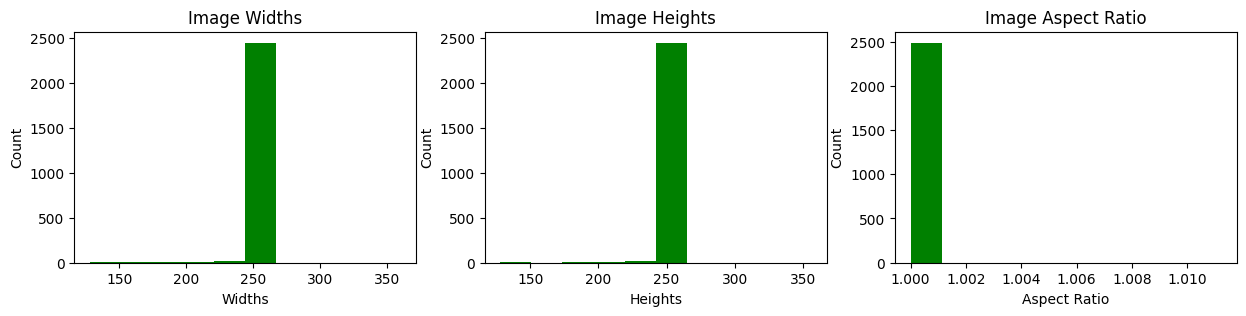

In [65]:
# Get the distribution on the different widths, heights and the aspect ratio of the images
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].hist(image_widths, bins=10,color='green')
ax[0].set_title('Image Widths')
ax[0].set_xlabel('Widths')
ax[0].set_ylabel('Count')

ax[1].hist(image_heights, bins=10,color='green')
ax[1].set_title('Image Heights')
ax[1].set_xlabel('Heights')
ax[1].set_ylabel('Count')

ax[2].hist(image_aspect_ratio, bins=10,color='green')
ax[2].set_title('Image Aspect Ratio')
ax[2].set_xlabel('Aspect Ratio')
ax[2].set_ylabel('Count')

plt.show()

We can see from the plots that the dimensions of most of the images are 250 * 250 and only very few are of dimensions lower than 250. From the meme dimensions variable printed in the previous cell of plot, different dimensions values can be seen and the image count respective to the dimension.
From the aspect ratio it can be seen that we have the square images.
These steps are performed in order to identify the images that would require resizing (images with dimensions other than 250 * 250 ?) - To create the image embeddings we will use **[Inception_V3](https://pytorch.org/hub/pytorch_vision_inception_v3/)** model, and it requires the input size of 299x299x3. So, we will upscale the images. 

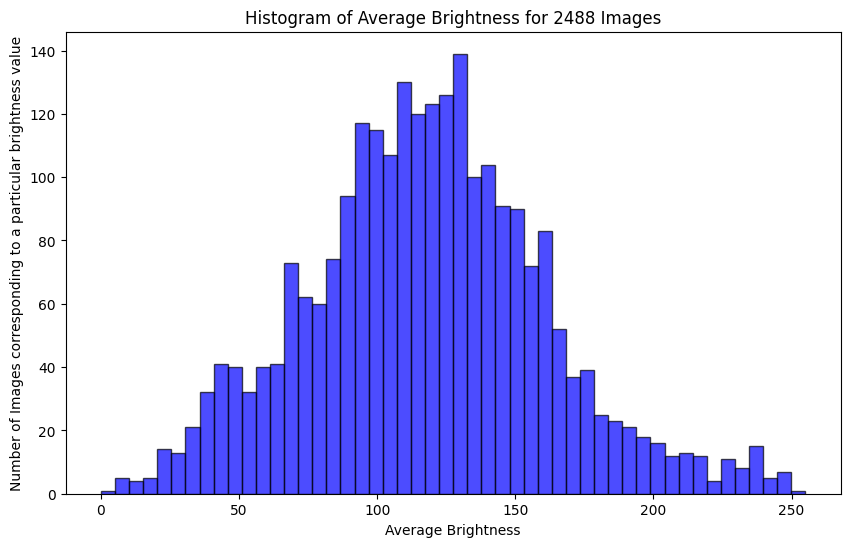

In [66]:
brightness_values = []
darker_image_names = []
lighter_image_names = []

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    # Load the image in greyscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Calculate average brightness
    avg_brightness = image.mean()

    # Check if average brightness is less than 50, append the image name to the darker_image_names list
    if avg_brightness < 30:
        darker_image_names.append(image_file)
    elif avg_brightness > 240:
        lighter_image_names.append(image_file)

    # For every image, append the average brightness to the list
    brightness_values.append(avg_brightness)

# Plot histogram of brightness values
plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=50, color='blue', alpha=0.7,edgecolor='black')
plt.title(f'Histogram of Average Brightness for {len(brightness_values)} Images')
plt.xlabel('Average Brightness')
plt.ylabel('Number of Images corresponding to a particular brightness value')

# plt.grid(True)
plt.show()

We can see there are some darker images with average brightness on the lower values and some lighter images on the high end values. Brightness can affect feature interpretation of images. May be beneficial to convert the darker image brightness to average image brightness to help in feature detection/interpretation (note to explore)

In [67]:
images_list = []
for dark_img in darker_image_names:
    image_path = os.path.join(image_dir, dark_img)
    images_list.append(EasyImage.from_file(image_path))

EasyImageList(images_list).html()


In [68]:
images_list = []
for light_img in lighter_image_names:
    image_path = os.path.join(image_dir, light_img)
    images_list.append(EasyImage.from_file(image_path))

EasyImageList(images_list).html()

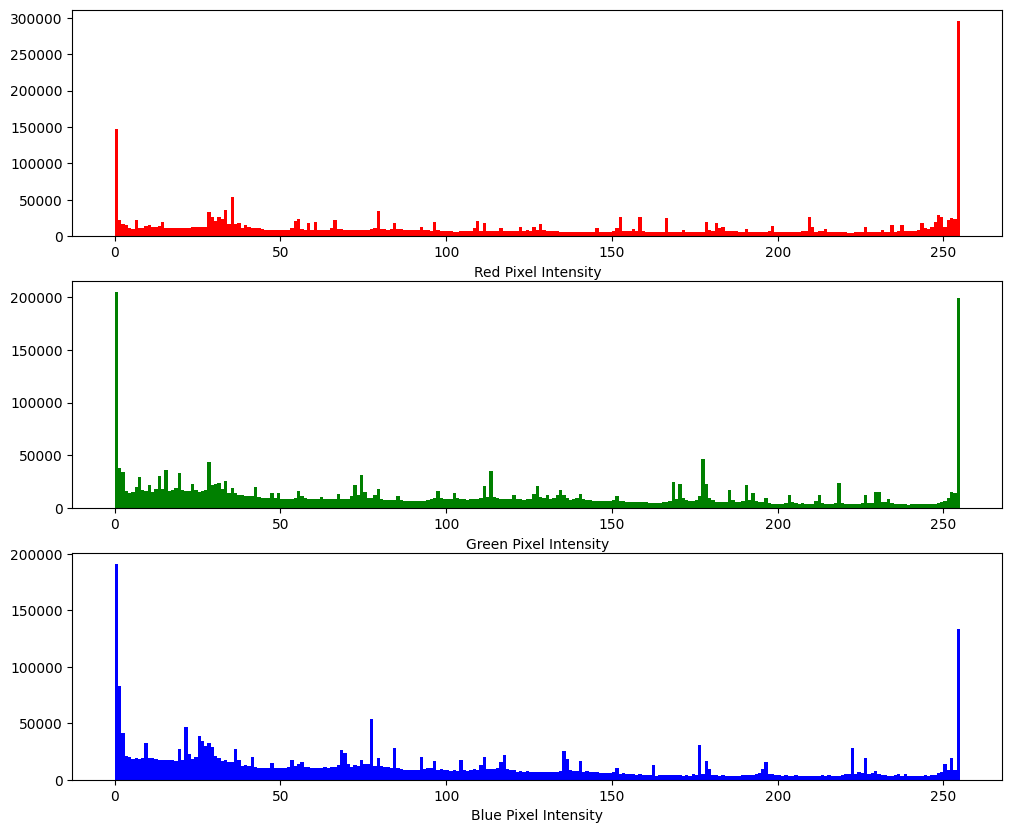

In [69]:
# Image color distribution
colors = {"R": [], "G": [], "B": []}

# For the 50 random images, plot the color distribution
for image_file in random.sample(image_files, 50):
    image = PIL.Image.open(os.path.join(image_dir, image_file))

    image_array = np.array(image)

    colors["R"].extend(image_array[:, :, 0].flatten())
    colors["G"].extend(image_array[:, :, 1].flatten())
    colors["B"].extend(image_array[:, :, 2].flatten())

    image.close()

# Plot color distribution
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
ax[0].hist(colors["R"], bins=255, color = 'red')
ax[0].set_xlabel("Red Pixel Intensity")

ax[1].hist(colors["G"], bins=255, color = 'green')
ax[1].set_xlabel("Green Pixel Intensity")

ax[2].hist(colors["B"], bins=255, color = 'blue')
ax[2].set_xlabel("Blue Pixel Intensity")

plt.show()

### Identification of the Images with text in it

In [70]:
def extract_text_easyocr(image_path,reader_instance):

    # Use the reader to read text from the image
    results = reader_instance.readtext(image_path)

    # Extract and return the text
    extracted_text = "\n".join([result[1] for result in results])
    if len(extracted_text.strip()) > 0:
        return extracted_text

# dictionary to hold the name of the image and the length of text in it
image_with_text = {}

# Create a reader instance
# The line reader = easyocr.Reader(['en']) is for loading a model into memory. It takes some time but it needs to be run only once.(https://github.com/JaidedAI/EasyOCR/tree/master)
print('Model is starting to get load into the memory')
reader = easyocr.Reader(lang_list=['en'], gpu=True, verbose=True)
print('Model loaded into the memory')

for image_file in tqdm.tqdm(image_files):
    image_path = os.path.join(image_dir, image_file) 

    text_retrieved = extract_text_easyocr(image_path,reader)

    if text_retrieved is not None:
        image_with_text[image_file] = text_retrieved  


Model is starting to get load into the memory
Model loaded into the memory


100%|██████████| 2488/2488 [00:52<00:00, 47.14it/s]


In [71]:
# Print sample of images identified with text

random.sample(list(image_with_text.items()), 5)

[('themoreyouknow.jpg', 'Rekoz%ou_noy'),
 ('ivan.jpg', '5'),
 ('overenthusiasticpflagmother.jpg', 'Toay som\nACEME 50\nproudi'),
 ('leitoraemdepre.jpg', '1'),
 ('berkstickets.jpg', 'Gicved')]

In [72]:
# Get the image name from the dictionary
image_with_text_list = [k for k, v in image_with_text.items()]

images_list = []
for img in image_with_text_list:
    image_path = os.path.join(image_dir, img)
    images_list.append(EasyImage.from_file(image_path,label=[img]))

EasyImageList(images_list).html(by_class=False)

# Note:- The Images have been identified which has text in them. These images are not removed right now, we will train the model
# and if the model output is not good, then we will remove the text from the images or we can remove the imges which just has text in it.

# Captions Text Exploration

In [73]:
# Read the captions file
captions = open(os.path.join(DATA_DIR, "captions.txt"), "r").read()

meme_names = {} # dictionary to store image filename and the meme name
meme_captions = {} # dictionary to store the image filename and the meme captions

previous_captions_img_filename = None

# Collect memes and their associated captions
for line in captions.split("\n"):
    # if the line does not contain a dash, it is a continuation of the previous caption
    if line.find('-') == -1 and previous_captions_img_filename is not None:
        meme_captions[previous_captions_img_filename][-1] += " " + line.strip()
        continue

    # Find the index of the dash which separates the image name and the caption
    split_index = line.index(' - ')
    name, caption = line[0:split_index].strip(), line[split_index + 3:].strip()

    # Ignore the empty meme caption
    if not caption:
        continue

    # generate meme image file name - remove special characters and convert to lowercase.
    # It would be an appropriate way to compare for which images captions are available, as
    # there are lot of discrepancies in the names format in image and captions file.
    captions_img_file_name = re.sub(r"[^a-zA-Z0-9]+", '', name.lower()) + ".jpg"

    # The meme_names is prepared to create the image file name so that it can be compared to which image the captions belong to
    meme_names[captions_img_file_name] = name

    # Add all the captions associated with the particular image
    meme_captions[captions_img_file_name] = meme_captions.get(captions_img_file_name, []) + [caption]

    previous_captions_img_filename = captions_img_file_name  # Add the processed image name


In [74]:
# Remove the hypens from the images filename to make it consistent with the filename created from captions names
image_filenames_without_dash = set(map(lambda x: x.replace('-', ''), image_files))

# Find the images for which there is no associated captions
no_captions = set(image_filenames_without_dash) - set(meme_captions.keys())
print(f'The total number of images for which no captions were found are :{len(no_captions)}')

# Print a random sample of images for which no captions were found
print('Sample of images with no captions')
random.sample(list(no_captions), 5)

# Need to remove the images for which the captions were not found from consideration in training samples

The total number of images for which no captions were found are :32
Sample of images with no captions


['TutorPP.jpg',
 'sbpgti.jpg',
 'vrn.jpg',
 'codaxanacasadossegredos3.jpg',
 'funes20aos.jpg']

In [75]:
# Delete these 32 captions from the images folder
for image_file in tqdm.tqdm(no_captions):
    os.remove(os.path.join(image_dir, image_file))

# Update the image files list
image_files = os.listdir(image_dir)

100%|██████████| 32/32 [00:00<00:00, 31083.31it/s]


In [77]:
# identify the index of the image file in set
list(image_filenames_without_dash).index('whynotluna.jpg')

1614

In [78]:
# Find out the captions for which there is no image available
no_image = set(meme_captions.keys()) - set(image_filenames_without_dash)
print(f'No. of captions for which no image file is available : {len(no_image)}')
no_image

# Note : The .jpg is coming because we have converted the name of the captions to .jpg format to match with image name
# That is how the dataset has been prepared.

No. of captions for which no image file is available : 3


{'duckdynasty.jpg', 'releasethekraken.jpg', 'snsd.jpg'}

In [79]:
# Remove the captions for which the image was not found
for filename in no_image:
    meme_captions.pop(filename)
    meme_names.pop(filename)

We decided to remove the captions for which no images were found because by including these captions, we have no context to what a corresponding image looks like. We feel that only captions with which we can analyze the image should be included for a cleaner and more accurate unique caption generation.

In [80]:
# Remove the image and it's associated captions for the completely dark and light image
meme_captions.pop('blankblack.jpg')  #black image
meme_names.pop('blankblack.jpg')

meme_captions.pop('blanktemplate.jpg') #white image
meme_names.pop('blanktemplate.jpg')

'Blank Template'

In [81]:
# Remove from the image folder also
os.remove(os.path.join(image_dir, 'blankblack.jpg'))
os.remove(os.path.join(image_dir, 'blanktemplate.jpg'))

In [82]:
image_files = os.listdir(image_dir)  # Read again, because some files have been removed

Text Pre-processing

* Remove multiple spaces
* Convert text to lowercase
* Convert non-english to english
* Convert contractions

In [23]:
# An example block
# caption = "Hello, this is some non-ASCII text: Café and Pokémon."
# caption = '¿Qué te gusta hacer?'
caption = 'No hablo español'
ascii_caption = unidecode(caption)

print(ascii_caption)

No hablo espanol


The function **preprocess_captions** is written to perform below steps - 
1. ***<u>Remove multiple spaces and multiple punctuation marks</u>*** : They will not add any value to the meme generation. Additionally, in the text exploration it was found that some of the captions only have the punctuation marks. Eg - '!!!!!!!!!', '.................'. For the memes we need text, so that our model can have better context.

2. ***<u>Convert Non-ASCII charcters to ASCII characters</u>***: We are generating memes in English language, and in English language there is no unicode characters.<br>
3. ***<u>Removal of URL's</u>***: URL's do not give any funny information about image. So, it will be unnecessary to keep URL's.<br>
4. ***<u>Expanded contractions</u>***: The contractions need to be expanded to remove ambiguity. For example - you're can mean "you are" and "you were". We are going to use the pre-trained embeddings GloVe, and it will be beneficial to expand contractions to ensure that each word aligns well with the pre-trained vectors. Furthermore, when we will train the model and will generate the memes, we can revisit the point.<br>
5. ***<u>Removed hypen and forward slash ocurring between words</u>***: It was done to reduce the vocabulary size.<br>
6. After performing all the above steps, the text was again checked for spaces.

In [24]:
# Example to check if __and / will be removed
re.sub(r'(?<=\w)[-\/_](?=\w)', ' ', 'teenager___posts/tumblr')

'teenager   posts tumblr'

In [28]:
def preprocess_captions(caption):
    """
    Preprocess the captions of the memes
    """

    # Remove multiple spaces and multiple punctuation marks
    caption = re.sub(r"\s+", " ", caption)
    # Replace same punctuation marks occurring multiple times with a single instance
    # caption = re.sub(r"([.?!])\1+", r"\1", caption)

    # Replace same punctuation marks occurring multiple times with a single instance
    caption = re.sub(r"([^A-Za-a0-9])\1+", r"\1", caption)
   
    # Change the non-ascii characters to ascii characters
    caption = unidecode(caption)

    # Remove URLs 
    caption = re.sub(r"http\S+", "", caption)

    # Expand contractions
    caption = contractions.fix(caption)

    # Split the words joined with hypen or forward slash
    # Eg - "a self-initiated-process" will be converted to - "a self initiated process"
    # caption = re.sub(r"([a-zA-Z0-9])[-\/]([a-zA-Z0-9])", r"\1 \2", caption)
    caption = re.sub(r'(?<=\w)[-\/_](?=\w)', ' ', caption)

    # Remove multiple spaces 
    caption = re.sub(r"\s+", " ", caption)

    return caption.lower()

# Check some of the examples
print(preprocess_captions('Sono economicamente messi peggio di noi italiani riescono a permettersi una rete migliore della nostra, tanto da definirsi "Iper-connessionati"'))
print(preprocess_captions('I told him we\'re sending the national un-watering team!'))
print(preprocess_captions('I told-him-we-are - a/team!'))
print(preprocess_captions('remake$$$$$$$$$$$$$$$'))

sono economicamente mesi pegio di noi italiani riescono a permetersi una rete migliore dela nostra, tanto da definirsi "iper conesionati"
i told him we are sending the national un watering team!
i told him we are - a team!
remake$


#### After performing the pre-processing step, it is checked that there are no duplicate captions for each of the image/caption name. If there are any duplicate captions those are removed.
It is also removed so while training the model, repetition and some bias is reduced towards specific terms showing in a specific order. 

In [29]:
# Remove duplicate captions from the array
for filename, captions in meme_captions.items():
    # Pre-process captions
    captions = list(map(preprocess_captions, captions))

    # Remove duplicate captions
    original_length = len(captions)

    # get the count of each caption
    counter = Counter(captions)

    # get the captions which are duplicate
    duplicates = [item for item, count in counter.items() if count > 1]

    # remove the duplicate captions
    meme_captions[filename] = list(set(captions))

    new_length = len(meme_captions[filename])

    # The below code is written so that on GitHub the long output is not generated
    if False and original_length != new_length:
        print("Removed {} duplicate captions from {}".format(
            original_length - new_length, filename
        ))
        # print the duplicate captions
        print("Duplicate captions: {}".format(duplicates))

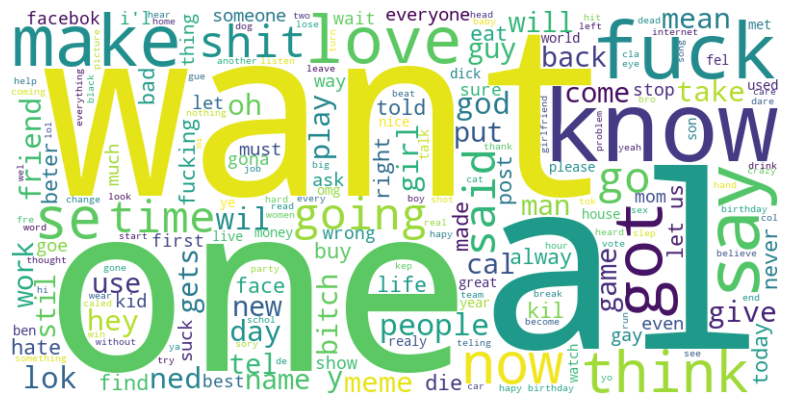

In [30]:
#Using unique captions to capture the most popular words

# Combining all of the captions into one long string
combined_text = " ".join(str(text) if isinstance(text, str) else " ".join(text) for text in meme_captions.values())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(combined_text) # Generating wordCloud

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From this Word Cloud we can see the most commonly occuring words within our meme captions. From this word cloud we can see tha a good amount of captions contain some angle of profanity, which will need to be replaced. We will likely replace the profanity with a series of specific characters. This Word Cloud contains Stop Words. We wanted to identify what words come more frequently as for our model, stopwords WILL be necessary in caption generation due to the nature of meme captions. 

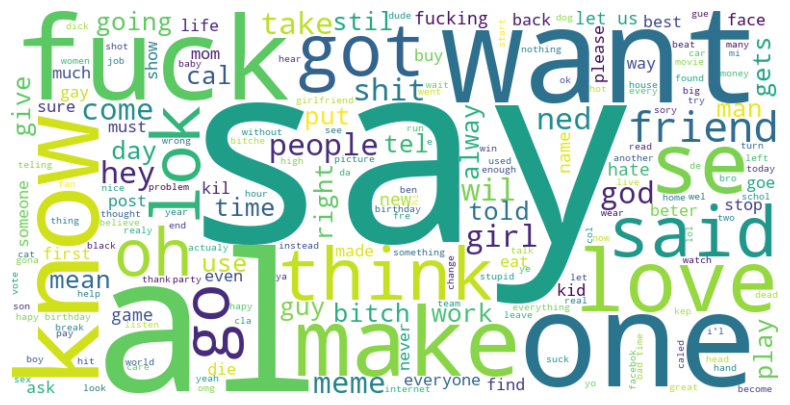

In [31]:

# split it into words
words = combined_text.split()

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from the sentence
filtered_sentence = [word for word in words if word.lower() not in stop_words]

# Join the filtered words back into a sentence
filtered_sentence = ' '.join(filtered_sentence)

wordcloud_noStop = WordCloud(width=800, height=400, background_color="white").generate(filtered_sentence) #Generating wordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_noStop, interpolation="bilinear")
plt.axis("off")
plt.show()

The above Word Cloud does not contain stopwords, giving us a look at higher word frequencies in our captions that are not stopwords. This Word Cloud is more for reference. We have decided to not omit stopwords from our training corpus for caption generation. 

Tokenizing all of the captions. We will use this when creating the text embedding.

In [32]:
# Generate vocabulary from the captions
tokenizer = get_tokenizer("basic_english")
vocab = []
for filename, captions in meme_captions.items():
    for caption in captions:
        # Add all the tokens created by (tokenizer(caption)) to the vocab list (extend adds multiple elements to the list)
        vocab.extend(tokenizer(caption))

print("Vocabulary size: {}".format(len(set(vocab))))

Vocabulary size: 146032


### Identify the occurrence of the least used words in captions. Analyze if those words would be worth keeping so that we can avoid unnecessary vocabulary size.

For count 1 ['nananananananananananananananananananananananananananananana', '#takesyouforevertoread', '01001100011001010111010001110011001000000110011101100101011101000010000001101001011101000010000001101111011011100010000001110100011011110110111001101001011001110110100001110100', 'analytics@socialbrothers', 'wubwubwubwawawaawobwobwob', 'fffffffffffuuuuuuuuuuuuu', 'ffffffffffuuuuuuuuuuuuuuuuuu', 'fffffffffuuuuuuuuuuuu-', 'fuuuuuuuuuuuuuuuuuuuuuuuuuuuuu', 'mmmmwwwaaaahhhaaahhhaaa', 'neishxjqoaopqkencnwiannwkanchwkanxkflwlxjrbwkansndnfkelnznw', 'gahwahfebenlebenargle', 'uuuuuuuuuuuuuuuugggggggggggggggg', 'asijfghiuayewfiaviuaytvjfevk', '23579888988588783701132217644322286884', '#wewantjustinstwiterback', 'fzw3gagv45vb254tgw564he7bh46bw6b546w7whn54nvqf455b3w6nj', 'jajajajajajajajajajaja', 'hahahahahahahahahahahahahahahahahaha', '#kilalstraightwhitemen', 'fapfapfapfapfapfapfap', 'heheheheheheheheheheh', 'intertouchdownception', 'auhejcofpqpfkcnrjsotjksjfnskclehx', 'aaaaaaaaaaaaaahhhhhhhhh

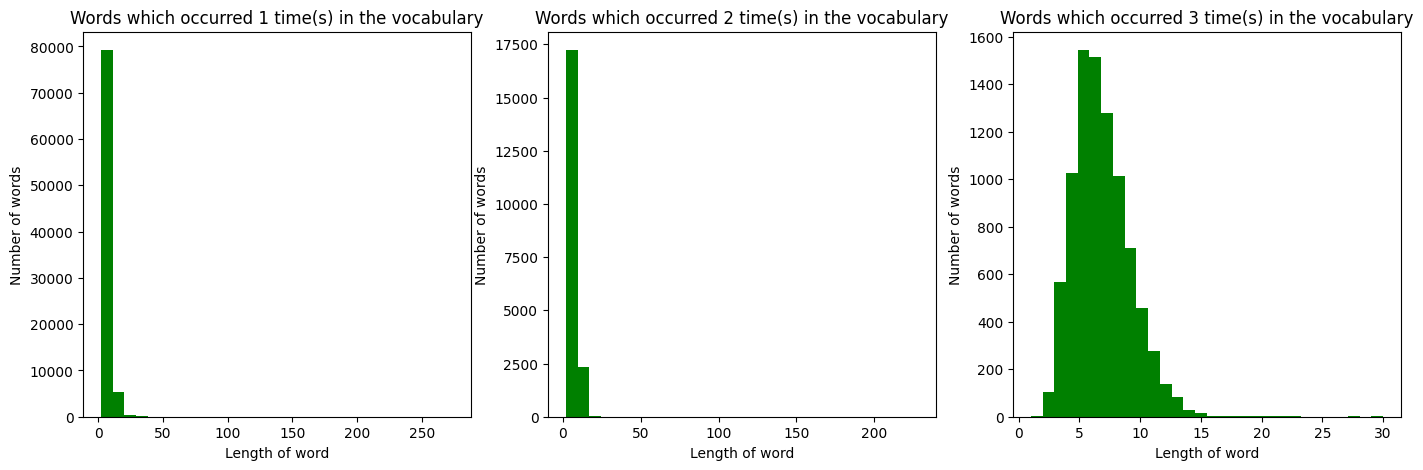

In [33]:
# Count the occurrence of words in vocabulary
wordcount = Counter(vocab)
# Plot the length of words which has the count of 1,2,3

# Create a subplot for each count
fig,ax = plt.subplots(1, 3, figsize=(17, 5))

for i in range(1,4):
    # Get the words which has the count equal to i
    words = [word for word, count in wordcount.items() if count == i]

    # Print the word which is of length > 20
    print(f'For count {i}',[word for word in words if len(word) > 20])   

    # Plot the histogram
    ax[i-1].hist([len(word) for word in words], bins=30,color='green')
    ax[i-1].set_title(f'Words which occurred {i} time(s) in the vocabulary')
    ax[i-1].set_xlabel("Length of word")
    ax[i-1].set_ylabel("Number of words")

# Note:- We can see the presence of words which would not make sense even for meme generation

We have analyzed that the words whose length is greater than 20 are not the good words i.e. they do not have any meaning even for memes. It seems like somebody have made the captions by just inputting random characters. Example - asijfghiuayewfiaviuaytvjfevk, 23579888988588783701132217644322286884. There are also captions which are just the numbers, so we want to remove those too. However, we will keep the text that starts with #tag.

In [34]:
# Get the words where length of the word is greater than 20, but remove the words which start with #
# from consideration of the words with length > 20.
# We have analyzed the words, and there are no words that start with word and have # between them (^'[^#].*#)
least_common_words = [word for word, count in wordcount.items() if len(word) > 20 and word[0] != '#']
least_common_words

['nananananananananananananananananananananananananananananana',
 '01001100011001010111010001110011001000000110011101100101011101000010000001101001011101000010000001101111011011100010000001110100011011110110111001101001011001110110100001110100',
 'mayoupleasrepethaword',
 'analytics@socialbrothers',
 'wubwubwubwawawaawobwobwob',
 'fffffffffffuuuuuuuuuuuuu',
 'ffffffffffuuuuuuuuuuuuuuuuuu',
 'fffffffffuuuuuuuuuuuu-',
 'fuuuuuuuuuuuuuuuuuuuuuuuuuuuuu',
 'mmmmwwwaaaahhhaaahhhaaa',
 'neishxjqoaopqkencnwiannwkanchwkanxkflwlxjrbwkansndnfkelnznw',
 'gahwahfebenlebenargle',
 'uuuuuuuuuuuuuuuugggggggggggggggg',
 'ahahahahahahahahahaha',
 'asijfghiuayewfiaviuaytvjfevk',
 '23579888988588783701132217644322286884',
 'fzw3gagv45vb254tgw564he7bh46bw6b546w7whn54nvqf455b3w6nj',
 'jajajajajajajajajajaja',
 'hahahahahahahahahahahahahahahahahaha',
 'fapfapfapfapfapfapfap',
 'heheheheheheheheheheh',
 'intertouchdownception',
 'auhejcofpqpfkcnrjsotjksjfnskclehx',
 'aaaaaaaaaaaaaahhhhhhhhhh',
 'oakxjspsnsjzn

In [35]:
# Replace the least common words with <unk>

for filename, captions in meme_captions.items():
    for i, caption in enumerate(captions):
        captions[i] = " ".join(
            [
                "<unk>" if word in least_common_words else word
                for word in tokenizer(caption)
            ]
        )

In [36]:
# Remove all captions with just <unk>, less than 3 tokens and just punctuations - to get more clean tokens
# which would be helphul in training the model

def is_valid_caption(caption):
    """
    Check if the caption is valid
    """
    
    tokens = tokenizer(caption)

    if len(tokens) < 3:  # Check if only 2 tokens are present
        return False

    if set(tokens) == {"<unk>"}: # Check if all the tokens are <unk>
        return False

    # Check if the tokens are alphanumeric
    alphanumeric_tokens = list(filter(lambda x: x.isalnum(), tokens))

    # If there are no alphanumeric tokens, then return false 
    if set(alphanumeric_tokens) == '':
        return False
    
    return True   
  

for filename, captions in meme_captions.items():
    # Collect the list of captions which were not valid, i.e would be removed
    invalid_captions = list(filter(lambda x: not is_valid_caption(x), captions))

    # Retrieve the valid captions (filter function is applied to each element of the iterable)
    captions = list(filter(is_valid_caption, captions))

    # Code written to avoid long outputs on GitHub
    if False and invalid_captions:
        print("Removed {} captions from {}".format(len(invalid_captions), filename))
        print("Removed captions are: {}".format(invalid_captions))

    meme_captions[filename] = captions

*Function **is_english_text** is written to identify the language of captions. We want all captions to be in English. The langdetect library was taking too much time to identify the language, so we resorted to [fasttext-langdetect library](https://pypi.org/project/fasttext-langdetect/).<br><br>
The fasttext-langdetect library was also not providing accurate results, so we adopted a custom technique, where we tokenize the captions and created <u>n=3 grams</u>. <br><br>
For all the n grams created for the processed caption, language detection was done individually using fasttext-langdetect. After language detection, we placed a condition --> if more than 30% of the n-grams belong to english language, then the processed caption will belong to English language, otherwise the caption will be appended to non_english_captions list.*

In [37]:
def is_english_text(caption):
    """
    Identification of the language of the text
    """

    tokens = tokenizer(caption)

    languages = [detect(text=ngram)["lang"] for ngram in ngrams_iterator(tokens, 3)]

    
    is_english = (
        len([lang for lang in languages if lang == "en"]) / len(languages)
    ) > 0.3

    return is_english

non_english_captions = []

# Idetify the non-english captions
for filename, captions in tqdm.tqdm(meme_captions.items()):
    for i, caption in enumerate(captions):
        if not is_english_text(caption):
            non_english_captions.append(caption)

print(len(non_english_captions))
random.sample(non_english_captions, 10)

100%|██████████| 2454/2454 [00:44<00:00, 55.58it/s]

30227


['librols you mad ?',
 'ricky -san !',
 'dum dum dum do de dum do de dum',
 'tylko honorarium jest za honorarium',
 'davy davy davy oh !',
 'trabalha them lisboa viva na margem sul',
 'na boa me da um beijo ?',
 "20 lukas de aguinaldo ? no nos alcanza pa ' las chelas !",
 'ute es weona o cree que esas minas van a ser mis universo',
 '14 2 2012']

In [38]:
# Checkpoint, save the preprocessed captions file
np.save(os.path.join(PROJECT_DIR, "non_english_captions.npy"), non_english_captions)

#### Update Non-English Captions

We want our captions all to be in English, so that our model can be trained properly in one language and does not provide random results.
We also want to make sure that we are not sending noise to the model, as meme generation itself is funky and humorous.

In [42]:
# Function to update non-english captions in meme_captions variable with identified english translation.
# The english translation is in the file - optimized_translated_captions.json
def update_meme_captions(meme_captions, optimized_translated_captions):   
    
    # Loop through the dictionary to replace the non-english captions with the english captions
    for filename, captions in tqdm.tqdm(meme_captions.items()):  
        # Loop through all the captions for the processed filename      
        for i, caption in enumerate(captions):
            # If the caption is found in the dictionary of optimized_translated_captions
            # then replace the meme_captions variable processed caption with the english caption
            if optimized_translated_captions.get(caption) is not None:
                meme_captions[filename][i] = optimized_translated_captions[caption]                    

In [43]:
TRANSLATED_CAPTIONS_DIR = os.path.join(PROJECT_DIR, "optimized_translated_captions.json")

# Load the optimized_translated_captions.json file into a Python dictionary
with open(TRANSLATED_CAPTIONS_DIR, 'r') as f:
    optimized_translated_captions = json.load(f)

# Call the function to update non-english captions in meme_captions variable
update_meme_captions(meme_captions, optimized_translated_captions)

100%|██████████| 2454/2454 [00:00<00:00, 47872.70it/s]


In [44]:
# Random spot check if the caption was correctly updated. With the help of printed file name, captions.txt was checked
for file,cap in meme_captions.items():
    for i,c in enumerate(cap):
        if c == 'I was the one who gave the prescription to Inter!':
            print(file)

michelemisseri.jpg


After updating the identified non-english captions with english captions, the fasttext-langdetect library was used again to know
if it still identifies text to be non-english. As we can see, it still marks 6712 captions as non-english captions, and when we analyzed
those captions they were actually not non-english. Additionally, we have used Google Translation for Translation and we know it is more robust and accurate.

We can say that the fasttext-langdetect is giving out the 6712 False Negatives for the English Class. It is due to the reason that the fasttext models are trained on data from Wikipedia, Tatoeba and SETimes which have the formal writing of text for 176 languages. In our scenario we have the memes which have very informal writing like use of short forms to represent words Example - "u" or "y" for "you', "wat" for "what", slangs, characters omitted from the correct spelling of the word etc. 

In [45]:
non_english_captions = []
# Translate captions to english
for filename, captions in tqdm.tqdm(meme_captions.items()):
    for i, caption in enumerate(captions):
        if not is_english_text(caption):
            non_english_captions.append(caption)

print(len(non_english_captions))
random.sample(non_english_captions, 10)

100%|██████████| 2454/2454 [00:43<00:00, 57.06it/s]

6712


['I am . luis alberto ppr',
 'sean come 2 me',
 'oh mer gerd berled shermp !',
 'meh ? !',
 'socrates ? plato ? marco pierre white',
 "i am andrzej fuckin ' americans",
 'rerberker ers rerterderd ter',
 'mas ilu o o',
 'ermahgerd twelve twelve twelve twerlve twerlve twelrve . etc',
 'r . i . p . suportershome']

In [46]:
# Finally save the preprocessed captions which are all in english language for future use
with open(os.path.join(DATA_DIR, "cleaned_english_captions.json"), "w") as f:
    json.dump(meme_captions, f)

## Image Preprocessing

In [85]:
#Resizing the images to be 299 x 299 as that is required by inception v3 model
#As all images are smaller than this size, we will need to upscale all images

resize_image_dir = os.path.join(DATA_DIR, "resized_memes") #Saving resized images to a new directory (created manually as a copy from original memes folder)

image_dimensions = {} #Holding new image dimensions

for image_file in image_files:  # Iterate on every meme image
    try:
        image = PIL.Image.open(os.path.join(resize_image_dir, image_file)) #Opening Image

        image = image.resize((299,299)) #Resizing image
        image.save(os.path.join(resize_image_dir, image_file)) #Saving resized image

        # get the count of images for each unique dimension
        image_dimensions[image.size] = image_dimensions.get(image.size, 0) + 1

        image.close() #Closing image

    # Exception handling
    except Exception as e:
        print("Could not read image file {}".format(image_file), e)
        image_broken += 1

print("Meme dimensions: {}".format(image_dimensions)) #Confirm all images are 299 x 299

Meme dimensions: {(299, 299): 2454}


Above is handling the physical resizing and saving of all images. A new folder names resized_memes was created manually as a copy from the memes folder. The new folder contained the same images and file names
as the original. We decided to resize the images in a new folder incase we wanted access to the images in their original form. 